In [11]:
import numpy as np

with np.load("../maml-randomShapeMaze/results.npz") as data_file:
    logs = {
        "tasks": data_file["tasks"],
        "train_returns" : data_file["train_returns"],
        "valid_returns" : data_file["valid_returns"],
        # "train_episodes" : data_file["train_episodes"],
        # "valid_episodes" : data_file["valid_episodes"],
    }

KeyError: 'train_episodes is not a file in the archive'

In [4]:
display(logs["tasks"].shape)
display(logs["train_returns"].shape)
display(logs["valid_returns"].shape)

(400, 50, 50)

(400, 20)

(400, 20)

In [5]:
display(logs["tasks"][0])
display(logs["train_returns"][0,:])
display(logs["valid_returns"][0,:])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

array([ -45.560005 ,   -3.9799998,   -6.95     ,  -23.78     ,
        -13.879999 , -200.       ,   -6.949999 ,   -8.93     ,
        -10.909999 ,  -13.879999 ,  -35.660004 ,  -21.8      ,
        -11.9      ,  -17.84     ,   -6.949999 ,  -29.720001 ,
         -9.92     , -200.       ,  -60.41001  ,  -21.8      ],
      dtype=float32)

array([ -27.739998 ,  -13.879999 ,  -15.859999 ,  -10.91     ,
        -15.859999 , -200.       ,   -3.9799995,  -13.879999 ,
        -22.789997 ,   -5.96     ,  -44.57001  ,  -10.91     ,
        -22.789999 ,  -25.759998 ,  -26.749998 ,  -13.879999 ,
        -35.660004 , -200.       ,   -5.959999 ,  -45.560005 ],
      dtype=float32)

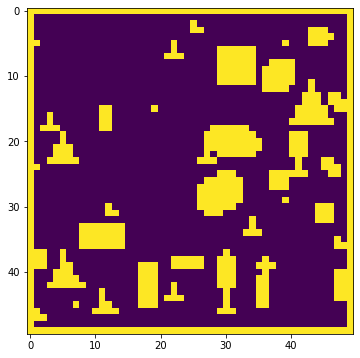

In [6]:
import matplotlib.pyplot as plt

x = logs["tasks"][0]
fig = plt.figure(figsize=(6,6))
plt.imshow(x)
plt.show()

In [10]:
logs["train_returns"][0]

array([ -45.560005 ,   -3.9799998,   -6.95     ,  -23.78     ,
        -13.879999 , -200.       ,   -6.949999 ,   -8.93     ,
        -10.909999 ,  -13.879999 ,  -35.660004 ,  -21.8      ,
        -11.9      ,  -17.84     ,   -6.949999 ,  -29.720001 ,
         -9.92     , -200.       ,  -60.41001  ,  -21.8      ],
      dtype=float32)